In [2]:
import msprime
import tskit
import numpy as np
import scipy as sp
import numba
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
def strip_MAC(ts, MAC):
    """
    Removes sites with minor allele count <= MAC.
    Returns a new tree-sequence with sites removed
    """

    initial_sites = ts.num_sites
    present_samples = np.intersect1d(
        ts.samples(),
        np.where(ts.tables.nodes.asdict()['time'] == 0)[0]
    )
    npresent_samples = len(present_samples)

    sites_to_remove = []
    for tree in ts.trees(tracked_samples=present_samples):
        for site in tree.sites():
            assert len(site.mutations) == 1  # Only supports infinite sites muts.
            mut = site.mutations[0]
            if (tree.num_tracked_samples(mut.node) <= MAC) or \
                (tree.num_tracked_samples(mut.node) >= (npresent_samples - MAC)):
                sites_to_remove.append(site.id)

    ts = ts.delete_sites(sites_to_remove)
    final_sites = ts.num_sites
    print(f"MAC filter (<={MAC}):")
    print(f"removed {initial_sites-final_sites} sites ({(initial_sites-final_sites)/(initial_sites):.0%}), {final_sites} sites remain")
    return ts

In [4]:
def downsample_snps(ts, nsnps, seed, fail=False):
    """downsample a tree-sequence to a maximum number of snps
    if fail is True, will fail if there are not at least nsnps"""
    initial_sites = ts.num_sites
    if ts.num_mutations == nsnps:
        return(ts)
    elif ts.num_mutations < nsnps:
        if fail:
            assert False, "less than {nsnps} are present and fail=True"
        else:
            return(ts)
    else:
        rng = np.random.default_rng(seed)
        keep = frozenset(np.random.choice(a=ts.num_mutations, size=nsnps, replace=False))

        # RKW new way to do this
        keep = frozenset(np.random.choice(a=ts.num_sites, size=nsnps, replace=False))
        sites_to_remove = list(frozenset(np.arange(ts.num_sites, dtype = np.int32)) - keep)
        ts = ts.delete_sites(sites_to_remove)
        final_sites = ts.num_sites
        print('Downsample filter:')
        print(f"removed {initial_sites-final_sites} sites ({(initial_sites-final_sites)/(initial_sites):.0%}), {final_sites} sites remain")
        return(ts)

In [5]:
def get_depths(N, mean_depth):
    #N = ninds*nsites = (2*nhaps*nsites)
    depths = np.random.poisson(mean_depth, size = N)
    return(depths)
def sequence(gt, mean_depth, error_rate):
    nsite = gt.shape[0]
    nind = int(gt.shape[1]/2)
    N = nsite*nind
    depths = get_depths(N, mean_depth=mean_depth)
    depths = depths.reshape(nsite, nind)
    # allele of each read
    p = (gt[:, 0::2] + gt[:, 1::2])/2
    n1 = np.random.binomial(n=depths, p=p)
    n0 = depths-n1
    # add error to sequences
    nerr_n0 = np.random.binomial(n=n0, p=error_rate)
    nerr_n1 = np.random.binomial(n=n1, p=error_rate)
    n0 -= nerr_n0
    n1 += nerr_n0
    n0 += nerr_n1
    n1 -= nerr_n1
    return(depths, n0, n1)
def genotype_likelihoods(n0, n1, error_rate, rescale=True):
    """not implemented"""
    l00 = (1-err)**n0 * err**n1
    l11 = (1-err)**n1 * err**n0
    l01 =  (.5)**n0 * (.5)**n1
    gl = np.stack([l00, l01, l11])
    # rescaled
    if rescale:
        gl = (gl/gl.sum(0))
    return(gl)

def call_genotypes(gl):
    mlgt = np.argmax(gl, 0)
    return(mlgt)

def dosage_genotypes(gl):
    """assume flat prior on genotypes.
    Should only be applied to rescaled genotype likelihoods."""
    dosage_gt = 1 * gl[1] + 2 * gl[2]
    return(dosage_gt)

In [6]:
def get_r2_fast(geno_mat):
    norm_snps = (geno_mat - np.mean(geno_mat, 0)) / np.std(geno_mat, 0, ddof=1)
    norm_snps = norm_snps.T
    num_snps, num_indivs = norm_snps.shape
    ld_mat = (np.dot(norm_snps, norm_snps.T) / float(num_indivs-1))**2
    return(ld_mat)

In [7]:
def get_overall_mean(ld_mat):
    return(ld_mat[np.triu_indices_from(ld_mat, k=1)].mean())

In [8]:
def get_geno_codes(genos):
    """Map each pair of non-missing genotypes to an integer from 0 to 8.
    Pairs with missing genotypes will map above 8
    """
    return(genos[0] + 3 * genos[1])

In [9]:
def get_rand_hap_freqs():
    """Return numpy array of random haplotype frequencies.
    """
    H = np.diff(np.concatenate((np.array([0]), np.sort(np.random.rand(3)), np.array([1.0]))))
    H = H.astype(np.float64)
    return(H)

In [10]:
@numba.jit(nopython=True, nogil=False, cache=True)
def get_sumstats_from_haplotype_freqs(H):
	"""Return r^2, D, Dprime, and allele frequencies in each pop.
	Input is an array of four haplotype frequencies x populations.
	"""
	# 00, 01, 10, 11
	pA = H[2] + H[3]
	pB = H[1] + H[3]
	pAB = H[3]
	D = pAB - pA * pB
	# expected freqs
	pa = 1.0 - pA
	pb = 1.0 - pB
	pApB = pA * pB
	pApb = pA * pb
	papB = pa * pB
	papb = pa * pb
	A = np.minimum(pApb, papB)  # Dmax when D is positive
	B = np.minimum(pApB, papb)  # Dmax when D is negative
	Dmax = np.where(D >= 0, A, B)
	Dprime = np.abs(D / Dmax)  # now an absolute value
	r2 = (D**2) / (pA * pB * pa * pb)
	return(r2, D, Dprime, pA, pB)

In [11]:
# bit shifting taken from BCFTOOLS and ngsLD
# used to convert a pair of haplotype indexes (0:3) into genotype indexes, 
# if the genotypes are consistent with the haplotypes
# serves a similar function as the G arry in the prior EM function

@numba.jit(nopython=True)
def _G1(h, k):
    return((h>>1&1) + (k>>1&1))

@numba.jit(nopython=True)
def _G2(h,k):
    return((h&1) + (k&1))

# below with show how they are used
#for h in range(4):
#    for k in range(4):
#        print(_G1(h,k), _G2(h,k))
        
#for h in range(4):
#    for k in range(4):
#        print(_G1(h,k), _G2(h,k))

In [12]:
@numba.jit(nopython=True)
def do_EM(H, gl1, gl2, n_ind, max_iter):
    ff = np.zeros(4) # temporary storage
    Hnew = H.copy() # used to not overwrite the original H (haplotype frequencies)
    
    for i in range(1, max_iter + 1):
        ff.fill(0)
        for ind in range(n_ind):
            _sum = 0
            for k in range(4):
                for h in range(4):
                    raw = Hnew[k] * Hnew[h] * gl1[_G1(h,k), ind] * gl2[_G2(h,k), ind]
                    _sum += raw
            for k in range(4):
                _tmp = 0
                for h in range(4):            
                    raw = Hnew[k] * Hnew[h] * (gl1[_G1(h,k), ind] * gl2[_G2(h,k), ind] + gl1[_G1(k,h), ind] * gl2[_G2(k,h), ind])
                    _tmp += raw
                    
                ff[k] += _tmp /_sum
            
        for k in range(4):
            Hnew[k] = ff[k] / (2*n_ind)
        for k in range(4):
            Hnew[k] = Hnew[k] / Hnew.sum()

    return(Hnew)

In [13]:
def EM_loop(gl):
    nsites, n_ind = gl.shape[1], gl.shape[2]
    res = []
    for l1 in range(nsites):
        for l2 in range(l1+1, nsites):
            Hini = get_rand_hap_freqs()
            Hpost = do_EM(Hini, gl1=gl[:, l1, :], gl2=gl[:, l2, :], n_ind=n_ind, max_iter=50)
            r2, D, Dprime, pA, pB = get_sumstats_from_haplotype_freqs(Hpost)
            #Hini, Hpost, r2, pA, pB
            res.append(r2)
    res = np.array(res)
    return(res)

# simulate ts and filter sites
## extract diploid genotypes


In [14]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=500)

def sim(demography):
    demography = demography
    ts = msprime.sim_ancestry(
        demography=demography,
        #model='dtwf',
        model='hudson',
        samples=100, 
        sequence_length=1e7,
        recombination_rate=1e-8,
        discrete_genome=False
    )
    return(ts)
ts = sim(demography)

In [15]:
ts = msprime.sim_mutations(tree_sequence=ts, rate=1.44e-8, discrete_genome=False)
ts.num_mutations

ts = strip_MAC(ts, 10)
ts = downsample_snps(ts, 300, seed = None)

MAC filter (<=10):
removed 693 sites (44%), 870 sites remain
Downsample filter:
removed 570 sites (66%), 300 sites remain


In [16]:
gt = ts.genotype_matrix()
diploid_gt = gt[:, 0::2] + gt[:, 1::2]

## sequence at given depth and error rate
## call genotypes with same known error rate
### assumes biallelic sites, errors always wrong

In [17]:
err = 0.02 # chance a read gets the *wrong* allele
depths, n0, n1 = sequence(gt, mean_depth=10, error_rate=err)
gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=True)
mlgt = call_genotypes(gl)

# fraction of mismatching genotypes
f_mismatch = (diploid_gt != mlgt).sum() / diploid_gt.size
print(f'fraction of mismatching genotypes (calls vs true): {f_mismatch:0.3f}')


meanr2_true = get_overall_mean(get_r2_fast(diploid_gt.T))
print(f'mean r2 for true genotypes: {meanr2_true:0.4f}')

meanr2_ml = get_overall_mean(get_r2_fast(mlgt.T))
print(f'mean r2 for called genotypes: {meanr2_ml:0.4f}')

# genotype likelihoods should be rescaled
dosage_gt = dosage_genotypes(gl)
meanr2_dosage = get_overall_mean(get_r2_fast(dosage_gt.T))
print(f'mean r2 for expected genotypes (genotype dosage): {meanr2_dosage:0.4f}')

fraction of mismatching genotypes (calls vs true): 0.028
mean r2 for true genotypes: 0.0494
mean r2 for called genotypes: 0.0427
mean r2 for expected genotypes (genotype dosage): 0.0440


In [18]:
err = 0.02 # chance a read gets the *wrong* allele
depths, n0, n1 = sequence(gt, mean_depth=2, error_rate=err)
gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=True)
mlgt = call_genotypes(gl)

# fraction of mismatching genotypes
f_mismatch = (diploid_gt != mlgt).sum() / diploid_gt.size
print(f'fraction of mismatching genotypes (calls vs true): {f_mismatch:0.3f}')


meanr2_true = get_overall_mean(get_r2_fast(diploid_gt.T))
print(f'mean r2 for true genotypes: {meanr2_true:0.4f}')

meanr2_ml = get_overall_mean(get_r2_fast(mlgt.T))
print(f'mean r2 for called genotypes: {meanr2_ml:0.4f}')

# genotype likelihoods should be rescaled
dosage_gt = dosage_genotypes(gl)
meanr2_dosage = get_overall_mean(get_r2_fast(dosage_gt.T))
print(f'mean r2 for expected genotypes (genotype dosage): {meanr2_dosage:0.4f}')

fraction of mismatching genotypes (calls vs true): 0.237
mean r2 for true genotypes: 0.0494
mean r2 for called genotypes: 0.0176
mean r2 for expected genotypes (genotype dosage): 0.0189


# do the EM

In [31]:
ld_EM = EM_loop(gl)

# compare to other results

In [32]:
ld_mat = get_r2_fast(diploid_gt.T)
ld_true = ld_mat[np.triu_indices_from(ld_mat, k=1)]
ld_true

array([8.96989313e-05, 2.04466966e-02, 2.20237030e-02, ...,
       1.00000000e+00, 3.92156863e-02, 3.92156863e-02])

In [33]:
ld_mat = get_r2_fast(mlgt.T)
ld_ml = ld_mat[np.triu_indices_from(ld_mat, k=1)]
ld_ml

array([0.00097943, 0.03051666, 0.00568182, ..., 0.73046831, 0.04641267,
       0.04518558])

In [34]:
ld_mat = get_r2_fast(dosage_gt.T)
ld_dosage = ld_mat[np.triu_indices_from(ld_mat, k=1)]
ld_dosage

array([0.00083446, 0.03549699, 0.01643658, ..., 0.76956279, 0.05462603,
       0.04428196])

In [41]:
df = pd.DataFrame.from_dict({
    'dosage': ld_dosage, 
    'called': ld_ml,
    'truth': ld_true,
    'GL': ld_EM,
})

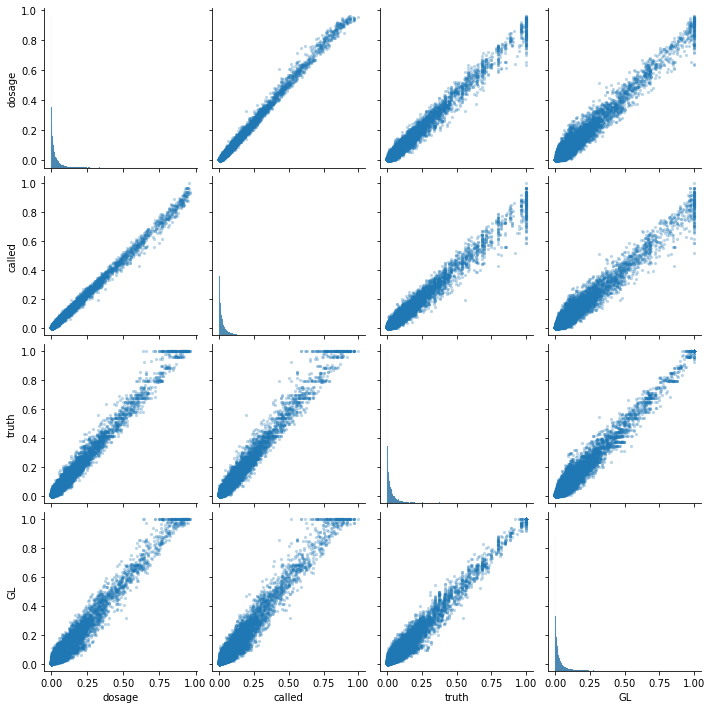

In [46]:
sns.pairplot(df, plot_kws=dict(s=10, linewidth=0, alpha = .3),)

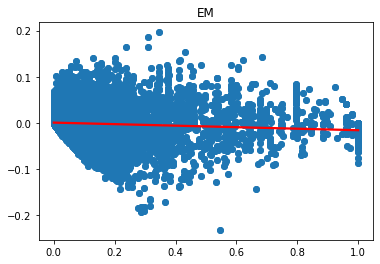

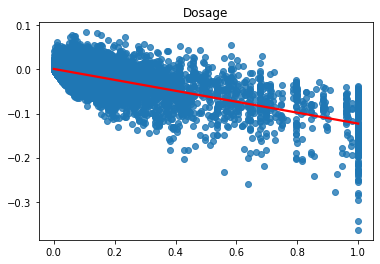

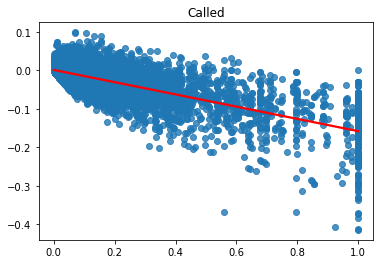

In [72]:

order = np.argsort(ld_true)
plt.scatter(ld_true[order], ld_EM[order]- ld_true[order] )
sns.regplot(x=ld_true[order], y=ld_EM[order]- ld_true[order], ci=None, line_kws={'color': 'red'})

plt.title('EM')
plt.show()

sns.regplot(x=ld_true[order], y=ld_dosage[order]- ld_true[order], ci=None, line_kws={'color': 'red'})

plt.title('Dosage')
plt.show()

sns.regplot(x=ld_true[order], y=ld_ml[order]- ld_true[order], ci=None, line_kws={'color': 'red'})
plt.title('Called')
plt.show()


## Now look across a range of depths

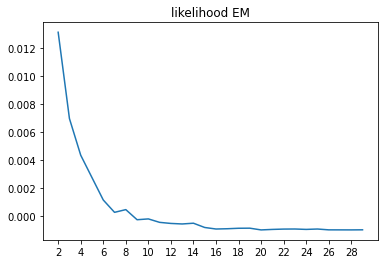

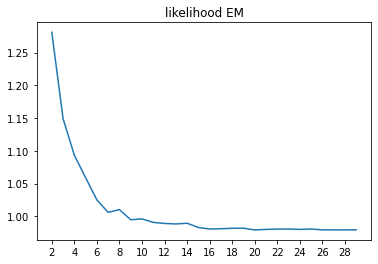

In [79]:
depth_abs_bias = []
depth_rel_bia = []
for depth in range(2, 30):
    depths, n0, n1 = sequence(gt, mean_depth=depth, error_rate=err)
    gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=True)
    mlgt = call_genotypes(gl)

    # genotype likelihoods should be rescaled
    dosage_gt = dosage_genotypes(gl)
    get_overall_mean(get_r2_fast(dosage_gt.T))

    ld_EM = EM_loop(gl)

    absolute_bias = ld_EM.mean() - get_overall_mean(get_r2_fast(diploid_gt.T))
    relative_bias = ld_EM.mean()/get_overall_mean(get_r2_fast(diploid_gt.T))
    depth_abs_bias.append(absolute_bias)
    depth_rel_bia.append(relative_bias)

plt.plot(range(2, 30), depth_abs_bias)
plt.xticks(range(2, 30, 2))
plt.title('likelihood EM')
plt.show()

plt.plot(range(2, 30), depth_rel_bia)
plt.xticks(range(2, 30, 2))
plt.title('likelihood EM')
plt.show()

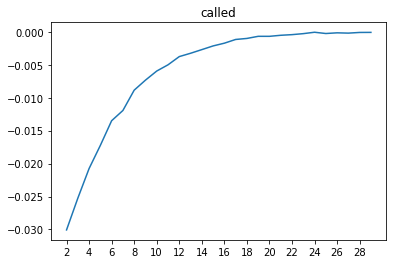

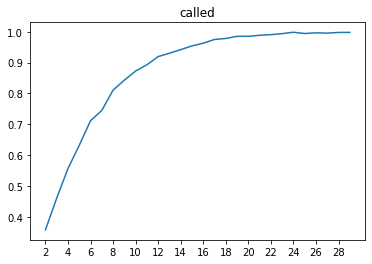

In [80]:
depth_abs_bias = []
depth_rel_bia = []
for depth in range(2, 30):
    depths, n0, n1 = sequence(gt, mean_depth=depth, error_rate=err)
    gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=True)
    mlgt = call_genotypes(gl)

    # genotype likelihoods should be rescaled
    dosage_gt = dosage_genotypes(gl)
    get_overall_mean(get_r2_fast(dosage_gt.T))

    absolute_bias = get_overall_mean(get_r2_fast(mlgt.T)) - get_overall_mean(get_r2_fast(diploid_gt.T))
    relative_bias = get_overall_mean(get_r2_fast(mlgt.T))/get_overall_mean(get_r2_fast(diploid_gt.T))
    depth_abs_bias.append(absolute_bias)
    depth_rel_bia.append(relative_bias)

plt.plot(range(2, 30), depth_abs_bias)
plt.xticks(range(2, 30, 2))
plt.title('called')
plt.show()

plt.plot(range(2, 30), depth_rel_bia)
plt.xticks(range(2, 30, 2))
plt.title('called')
plt.show()

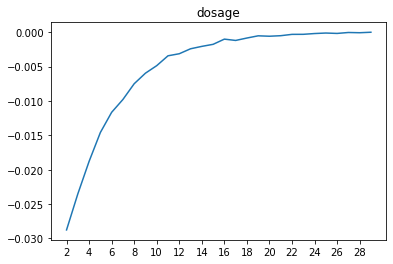

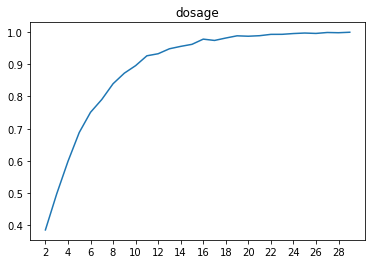

In [81]:
depth_abs_bias = []
depth_rel_bia = []
for depth in range(2, 30):
    depths, n0, n1 = sequence(gt, mean_depth=depth, error_rate=err)
    gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=True)
    mlgt = call_genotypes(gl)

    # genotype likelihoods should be rescaled
    dosage_gt = dosage_genotypes(gl)
    get_overall_mean(get_r2_fast(dosage_gt.T))

    absolute_bias = get_overall_mean(get_r2_fast(dosage_gt.T)) - get_overall_mean(get_r2_fast(diploid_gt.T))
    relative_bias = get_overall_mean(get_r2_fast(dosage_gt.T))/get_overall_mean(get_r2_fast(diploid_gt.T))
    depth_abs_bias.append(absolute_bias)
    depth_rel_bia.append(relative_bias)

plt.plot(range(2, 30), depth_abs_bias)
plt.xticks(range(2, 30, 2))
plt.title('dosage')
plt.show()

plt.plot(range(2, 30), depth_rel_bia)
plt.xticks(range(2, 30, 2))
plt.title('dosage')
plt.show()

In [645]:
nsites, n_ind = gl.shape[1], gl.shape[2]
res = []
for l1 in range(nsites):
    for l2 in range(l1+1, nsites):
        Hini = get_rand_hap_freqs()
        Hpost = do_EM(Hini, gl1=gl[:, l1, :], gl2=gl[:, l2, :], n_ind=n_ind, max_iter=50)
        r2, D, Dprime, pA, pB = get_sumstats_from_haplotype_freqs(Hpost)
        #Hini, Hpost, r2, pA, pB
        res.append(r2)
res = np.array(res)

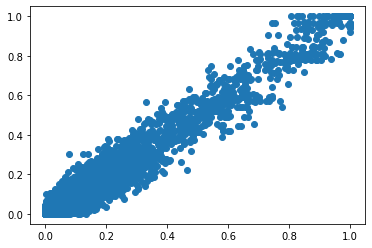

In [649]:
ld_mat = get_r2_fast(diploid_gt.T)
test = ld_mat[np.triu_indices_from(ld_mat, k=1)]

plt.scatter(x=res, y=test)

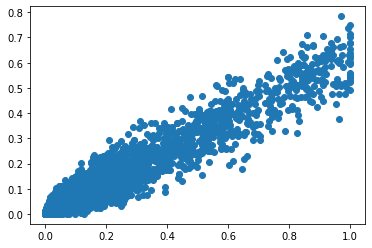

In [647]:
ld_mat = get_r2_fast(mlgt.T)
test = ld_mat[np.triu_indices_from(ld_mat, k=1)]
plt.scatter(x=res, y =test)

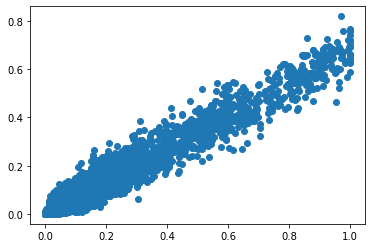

In [648]:
ld_mat = get_r2_fast(dosage_gt.T)
test = ld_mat[np.triu_indices_from(ld_mat, k=1)]
plt.scatter(x=res, y =test)

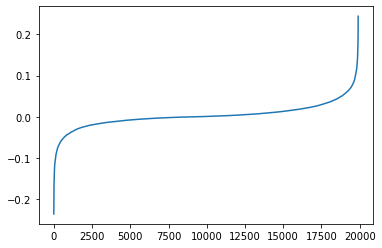

In [655]:
plt.plot(sorted(res-test))

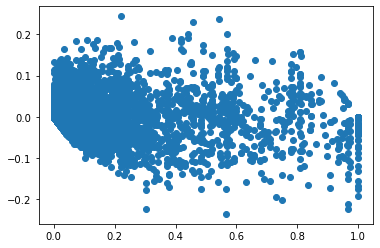

In [661]:
plt.scatter(test[np.argsort(test)], res[np.argsort(test)]- test[np.argsort(test)] )

In [684]:
gt = ts.genotype_matrix()
diploid_gt = gt[:, 0::2] + gt[:, 1::2]

depth_abs_bias = []
depth_rel_bia = []
for depth in range(2, 30):
    err = 0.01 # chance a read gets the wrong allele
    depths, n0, n1 = sequence(gt, mean_depth=depth, error_rate=err)
    gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=True)
    mlgt = call_genotypes(gl)

    # fraction of mismatching genotypes
    (diploid_gt != mlgt).sum() / diploid_gt.size

    get_overall_mean(get_r2_fast(diploid_gt.T))

    get_overall_mean(get_r2_fast(mlgt.T))

    # genotype likelihoods should be rescaled
    dosage_gt = dosage_genotypes(gl)
    get_overall_mean(get_r2_fast(dosage_gt.T))

    gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=False)
    nsites, n_ind = diploid_gt.shape
    res = []
    n = 0
    for l1 in range(nsites):
        for l2 in range(l1+1, nsites):
            Hini = get_rand_hap_freqs()
            Hpost = do_EM(Hini, gl1=gl[:, l1, :], gl2=gl[:, l2, :], n_ind=n_ind, max_iter=50)
            r2, D, Dprime, pA, pB = get_sumstats_from_haplotype_freqs(Hpost)
            #Hini, Hpost, r2, pA, pB
            res.append(r2)
    res = np.array(res)

    absolute_bias = res.mean() - get_overall_mean(get_r2_fast(diploid_gt.T))
    relative_bias = res.mean()/get_overall_mean(get_r2_fast(diploid_gt.T))
    depth_abs_bias.append(absolute_bias)
    depth_rel_bia.append(relative_bias)

plt.plot(range(2, 30), depth_abs_bias)
plt.xticks(range(2, 30, 2))
plt.show()

plt.plot(range(2, 30), depth_rel_bia)
plt.xticks(range(2, 30, 2))
plt.show()

In [548]:
def newadd(string1, string2):
    a = str(int(string1[0]) + int(string2[0]))
    b = str(int(string1[1]) + int(string2[1]))
    return(a+b)
def newgen(string):
    a = int(string[0])
    b = int(string[1])
    return(str(a+3*b))

haps = ['00', '01', '10', '11']
for i in range(4):
    for j in range(4):
        a = newadd(haps[i], haps[j])
        print(a, newgen(a))

00 0
01 3
10 1
11 4
01 3
02 6
11 4
12 7
10 1
11 4
20 2
21 5
11 4
12 7
21 5
22 8


In [550]:
@numba.jit(nopython=True)
def _G1(h, k):
    return((h>>1&1) + (k>>1&1))

@numba.jit(nopython=True)
def _G2(h,k):
    return((h&1) + (k&1))
for h in range(4):
    for k in range(4):
        print(_G1(h,k), _G2(h,k))
        
for h in range(4):
    for k in range(4):
        print(_G1(h,k), _G2(h,k))

0 0
0 1
1 0
1 1
0 1
0 2
1 1
1 2
1 0
1 1
2 0
2 1
1 1
1 2
2 1
2 2
0 0
0 1
1 0
1 1
0 1
0 2
1 1
1 2
1 0
1 1
2 0
2 1
1 1
1 2
2 1
2 2


In [566]:
gl = genotype_likelihoods(n0, n1, error_rate=err, rescale=False)
Hini = get_rand_hap_freqs()
Hpost = do_EM(Hini, gl1=gl1, gl2=gl2, n_ind=gl1.shape[1], max_iter=50)
r2, D, Dprime, pA, pB = get_sumstats_from_haplotype_freqs(Hpost)

Hini, Hpost, r2, pA, pB

(array([0.58763204, 0.07017031, 0.2402316 , 0.10196604]),
 array([0.46882476, 0.19617524, 0.03117524, 0.30382476]),
 0.333689859892426,
 0.33499999999999985,
 0.5)

In [527]:
Hpost

array([0.56800693, 0.36336794, 0.20717736, 0.99947802])

In [484]:
diploid_gt.mean(1)/2

array([0.335, 0.5  ])

In [467]:
@numba.jit(nopython=True)
def do_EM(H, gl1, gl2, n_ind, max_iter):
    # which combinations of haplotypes produce which genotypes
    # 00, 01, 10, 11
    G = np.array([0, 3, 1, 4, 3, 6, 4, 7, 1, 4, 2, 5, 4, 7, 5, 8])
    
    norm = np.zeros(n_ind)
    isum = np.zeros((n_ind, 4)) 
    post = np.zeros(4)
    Hnew = H.copy()
    
    # TODO change order of the loop to prevent useless looping?
    # start iteration here
    for i in range(1, max_iter + 1):
        norm.fill(0)
        isum.fill(0)
        for hap1 in range(4): # index of haplotype in first spot
            for hap2 in range(4): # index of haplotype in second spot
                for g1 in range(2):
                    for g2 in range(2):
                        code = g1 + 3 * g2 # eg 0_1 -> 3, 1_1 -> 4, 2_0 -> 6
                        # if the current pair of haplotypes is consistent with the pair of genotypes'
                        if code == G[4 * hap1 + hap2]:
                            for ind in range(n_ind):
                                raw = Hnew[hap1] * gl1[g1, ind] * Hnew[hap2] * gl2[g2, ind]
                                isum[ind, hap1] += raw
                                isum[ind, hap2] += raw
                                norm[ind] += raw
        
        # normalized sum over individuals
        post.fill(0)
        for ind in range(n_ind):
            for hap in range(4):
                post[hap] += isum[ind, hap] / norm[ind]
        #return(post)
        Hsum = post/post.sum()
        for j in range(4):
            Hnew[j] = Hsum[j]
    return(isum)
    return(Hnew)

In [475]:
isum = do_EM(Hini, gl1=gl1, gl2=gl2, n_ind=gl1.shape[1] , max_iter=50)


In [476]:
isum.sum(0)/isum.sum()

array([3.78912333e-01, 3.84033608e-01, 2.36842610e-01, 2.11449737e-04])

In [457]:
Hini = get_rand_hap_freqs()
Hpost = do_EM(Hini, gl1=gl1, gl2=gl2, n_ind=gl1.shape[1] , max_iter=5)
r2, D, Dprime, pA, pB = get_sumstats_from_haplotype_freqs(Hpost)

Hini, Hpost, r2, pA, pB

(array([0.43277308, 0.37872307, 0.1802431 , 0.00826076]),
 array([0.36137735, 0.36362265, 0.26362265, 0.01137735]),
 0.18013906913762667,
 0.27500000000000024,
 0.37500000000000006)

In [435]:
diploid_gt.mean(1)/2

array([0.335, 0.5  ])

In [436]:
mlgt.mean(1)/2

array([0.335, 0.5  ])

In [437]:
dosage_gt.mean(1)/2

array([0.335, 0.5  ])

In [349]:
get_overall_mean(get_r2_fast(diploid_gt.T))

0.3162003903708522

In [319]:
np.bincount(diploid_gt.sum(0))

array([23, 19, 35, 14,  9])

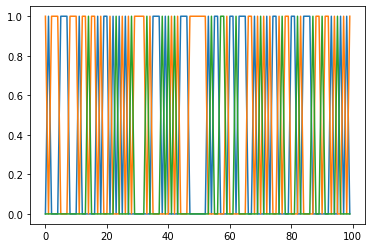

In [283]:
plt.plot(gl2.T)

In [34]:
gl1[1, 3]

7.025169794155771e-05

In [111]:
Hini

array([0.79639919, 0.06334167, 0.13525506, 0.00500408])

In [147]:
@numba.jit(nopython=True)
def do_EM(H, gl1, gl2, max_iter=None):

    n_ind = gl1.shape[1]
    if max_iter:
        pass
    else:
        max_iter = 10
    # which combinations of haplotypes produce which genotypes
    G = np.array([0, 3, 1, 4, 3, 6, 4, 7, 1, 4, 2, 5, 4, 7, 5, 8])
    
    n_geno_pair = 9 # number of unique pairs of genotypes

    norm = np.zeros(n_ind)
    isum = np.zeros((n_ind, n_geno_pair, 4)) # sum over the 9 possible genotype pairs in each ind
    post = np.zeros((n_geno_pair, 4))
    
    # start iteration here
    for i in range(1, max_iter + 1):
        norm.fill(0)
        isum.fill(0)
        for hap1 in range(4): # index of haplotype in first spot
            for hap2 in range(4): # index of haplotype in second spot
                for ind in range(n_ind):
                    for g1 in range(2):
                        for g2 in range(2):
                            code = 3*g1+g2
                            # if the current pair of haplotypes is consistent with the pair of genotypes'
                            if code == G[4 * hap1 + hap2]:
                                # likelihood of the haplotypes and genotypes 
                                raw = H[hap1] * gl1[g1, ind] * H[hap2] * gl2[g2, ind]
                                isum[ind, code, hap1] += raw.item()
                                isum[ind, code, hap2] += raw.item()
                                norm[ind] += raw.item()
        # avoid the division by zero due to missing data
        for j in range(len(norm)):
            if norm[j] == 0:
                norm[j] = 1
        
        # normalized sum over individuals
        post.fill(0)
        for ind in range(n_ind):
            for code in range(n_geno_pair):
                for hap in range(4):
                    # update post for each geno
                    post[code, hap] += isum[ind, code, hap] / norm[ind]  # can we use this estimate an 'effective sample size?'
        
        H = post.sum(0)/post.sum()
    return(H)

In [148]:
Hini = get_rand_hap_freqs()
Hpost = do_EM(Hini, gl1=gl1, gl2=gl2, max_iter=50)


(array([0.79639921, 0.06334165, 0.13525503, 0.0050041 ]),
 array([0.46947045, 0.10084939, 0.2161749 , 0.21350525]),
 0.0027343085039260185)

In [ ]:
r2, *_ = get_sumstats_from_haplotype_freqs(Hpost)
r2

In [ ]:
# 00, 01, 10, 11
# haplotype likelihoods
hl = np.zeros((gl1.shape[1], 4))
hl[:, 0] = gl1[0]*gl2[0]

In [ ]:
gl1[0]*gl2[0]

In [ ]:
do_EM(Hini, gl1=gl[:, 0, :], gl2=gl[:, 1, :])


In [ ]:
gl1 = gl[:, 0, :]
gl2 = gl[:, 1, :]

In [ ]:
l00 = (1-err)**n0 * err**n1
l11 = (1-err)**n1 * err**n0
l01 =  (.5)**n0 * (.5)**n1

# maximum like calls
gl = np.stack([l00, l01, l11])
# rescaled
gl = (gl/gl.sum(0))
mlgt = np.argmax(gl, 0)

In [ ]:
# maximum like calls
gl = np.stack([l00, l01, l11])
# rescaled
gl = (gl/gl.sum(0))
mlgt = np.argmax(gl, 0)

In [ ]:
mlgt

In [ ]:
diploid_gt

In [ ]:
get_overall_mean(get_r2_fast(mlgt.T))

In [ ]:
# number of mismatching genotypes
(diploid_gt != mlgt).sum()

In [ ]:
l01

In [ ]:
np.diagonal(r)


In [ ]:
import seaborn as sns
r=  get_r2_fast(mlgt.T)
np.fill_diagonal(r, np.nan)
sns.heatmap(np.log10(r+.00001))

In [ ]:
depths, n0, n1 = sequence(gt, 14)
#gt[:, 0::2] & nhap0
#gt[:, 1::2] & nhap1

In [ ]:
l00

In [ ]:
n1

In [ ]:
# add error to some reads
nerr_n0 = np.random.binomial(n=n0, p=0.002)
nerr_n1 = np.random.binomial(n=n1, p=0.002)
n0 -= nerr_n0
n1 += nerr_n0
n0 += nerr_n1
n1 -= nerr_n1

In [ ]:
n0.sum()

In [ ]:
n1.sum()